<a href="https://colab.research.google.com/github/kashyab12/RAN-Slicing-Simulation/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-cairo python3-matplotlib
!pip install import_ipynb

Executing: /tmp/apt-key-gpghome.kj6k1IA5lu/gpg.1.sh --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: "Tiago de Paula Peixoto <tiago@skewed.de>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://downloa

In [19]:
# Cloning Repo and setting it as the working Directory
%cd /content/
!rm -r RAN-Slicing-Simulation
!git clone https://github.com/kashyab12/RAN-Slicing-Simulation.git
%cd RAN-Slicing-Simulation/

/content
Cloning into 'RAN-Slicing-Simulation'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 68 (delta 26), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (68/68), done.
/content/RAN-Slicing-Simulation


In [42]:
import import_ipynb
import Substrate as sbs
import RanSlice as rn
from graph_tool.all import *

In [43]:
# Initiailzing the Substrate Network

sbs.setSbsNetworkProperties()
sbs.createSbsTowers()
sbs.setSbsTowerProperties()
sbs.createSbsTowerConnections()

In [44]:
# Initiailzing the RAN Slices

rn.createRANSlices()
rn.setRANSliceProperties()
rn.createVNFFunctions()
rn.setVNFFunctionProperties()
rn.createVNFConnections()

In [45]:
# Initializing the total network.

totalNetwork = Graph(directed=False)
totalNetwork = graph_union(totalNetwork, sbs.substrateNetwork, include = True, internal_props=True)
totalNetwork = graph_union(totalNetwork, rn.ranSlices[0], include = True, internal_props=True)

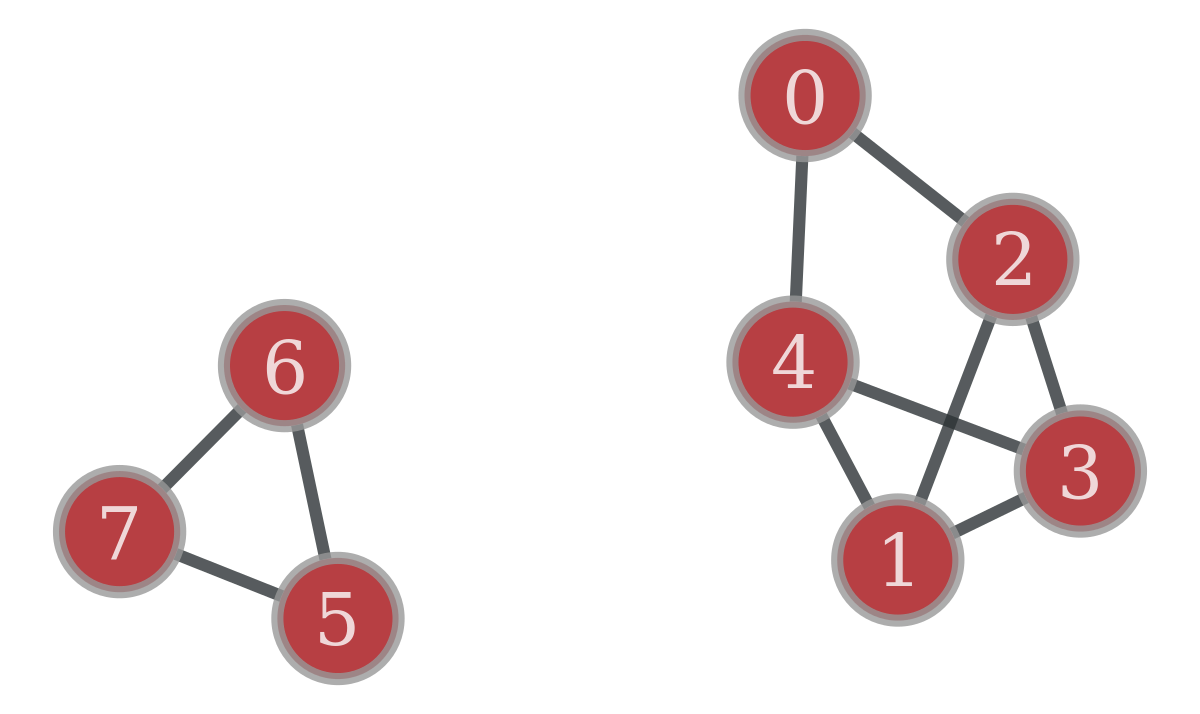

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f4354bd3978, at 0x7f4354a60240>

In [48]:
# Testing the Created Network

graph_draw(totalNetwork, vertex_text = totalNetwork.vertex_index)

In [71]:
# 1) Algorithm One

# a) Sorting the VNF Function Resource Values in decreasing order
sortedResVal = sorted(rn.resList, reverse=True)

sbsSpecVertex = 0
rnSpecVertex = 0

# b) Iterating through the sorted array
for resourceValue in sortedResVal:

  foundSbsVert = False

  # c) Finding the vertex with the specified resource value
  rnSpecVertex = find_vertex(totalNetwork, totalNetwork.vertex_properties.resources, resourceValue)

  for foundVertex in rnSpecVertex:
    if totalNetwork.vertex_properties.binaryMappingVar[foundVertex] == 0:
      break
    else:
      rnSpecVertex.pop(0)

  if not rnSpecVertex:
    continue

  # c) Find the neighbors of the found vertex and iterate through them
  isNeighborMapped = False

  for mappedNeighbors in rnSpecVertex[0].all_neighbors():
    if totalNetwork.vertex_properties.binaryMappingVar[mappedNeighbors] == 1:
      isNeighborMapped = True
    else:
      continue
  
  if isNeighborMapped == False:

    # Trying to find the Optimal Network Tower to Connect to

    for towerVertex in totalNetwork.vertices():
      if totalNetwork.vertex_properties.resourceCapacity[towerVertex] >= resourceValue and totalNetwork.vertex_properties.resourceCapacity[towerVertex] >= 0:
        print("Reached the Loop")
        sbsSpecVertex = towerVertex
        foundSbsVert = True
        break
      else:
        continue

    # In this case we are not worring about the Bandwidth since none of the Neighbors are mapped

    # Proceeding futher with the actual Mapping of the VNF Function to the Substrate Tower

    if foundSbsVert == False:
      continue
    else:
      totalNetwork.add_edge(sbsSpecVertex, rnSpecVertex[0])
      totalNetwork.vertex_properties.binaryMappingVar[rnSpecVertex[0]] = 1
      totalNetwork.vertex_properties.resourceCapacity[sbsSpecVertex] -= totalNetwork.vertex_properties.resources[rnSpecVertex[0]]

  else:
      




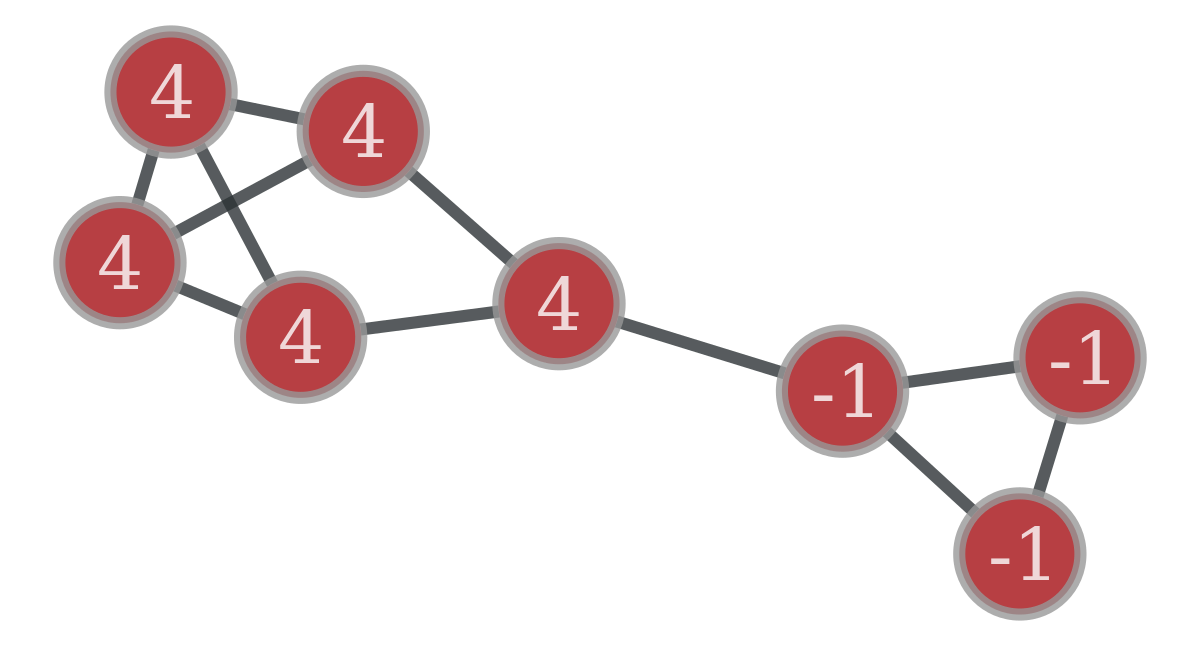

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f4354bd3978, at 0x7f434c0fda90>

In [72]:
graph_draw(totalNetwork, vertex_text = totalNetwork.vertex_properties.get("resourceCapacity"))